# Language detector

**Participants:**
- Roger Baiges
- Adrià Cantarero

**Subject:**
- Processament del Llenguatge Humà

**Course:** 2024

**Degree:** Intel·ligència Artificial


## IMPORTS

In [20]:
import re
import os
import glob
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

## 1. BASIC PREPROCESSING FUNCTIONS

In [21]:
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Delete numbers
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text)  # Delete multiple spaces
    text = re.sub(r'\n', '  ', text)  # Doble space for new line  
    return text

In [22]:
# Function to create trigrams given a text

def create_trigrams(text):
    characters = [char for char in text]
    return [''.join(trigram) for trigram in ngrams(characters, 3) if len(trigram) == 3]

## 2. READING THE DATA FUNCTIONS

In [24]:
import random

# Function to load the training and validation data from the files

def load_data_train_val(filenames):
    train_data = {}
    val_data = {}

    for file in filenames:
        with open(file, 'r', encoding='utf-8') as f:
            text = preprocess_text(f.read())
            sentences = text.split('  ')
            trigrams = create_trigrams(text)
            filename = os.path.basename(file).split('_')[0]
            train_data[filename] = trigrams.copy()

            # Randomly select 30% of the sentences for validation
            random.shuffle(sentences)
            split_index = int(len(sentences) * 0.3)
            val_sentences = sentences[:split_index]
            val_trigrams = create_trigrams(' '.join(val_sentences))
            val_data[filename] = val_trigrams

    return train_data, val_data


# Function to load the test data from the files

def load_data_test(filenames):
    texts = []
    labels = []
    for file in filenames:
        label = os.path.basename(file).split('_')[0]  # The tag is the first part of the filename
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                texts.append(line.strip())
                labels.append(label)
    return texts, labels


In [25]:
# Directory with the data files
train_files = glob.glob('langId/*_trn.txt')
test_files = glob.glob('langId/*_tst.txt')

# Load and store the data
train_data, val_data = load_data_train_val(train_files)
X_test, y_test = load_data_test(test_files)

## 3. FILTERING THE INFREQUENT TRIGRAMS

In [26]:
# Function to filter the infrequent trigrams (appear less than 5 times in a language)

def filter_infrequent_trigramsDICT(list_trigrams):
    # Count the frequency of each trigram in the list
    trigram_counts = Counter(list_trigrams)
    
    # Select the trigrams that appear at least 5 times
    frequent_trigrams = {trigram for trigram, count in trigram_counts.items() if count >= 5}
    
    # Filter the list of trigrams to include only the frequent trigrams
    filtered_list_trigrams = [trigram for trigram in list_trigrams if trigram in frequent_trigrams]
    
    return filtered_list_trigrams


In [27]:
for key in train_data:
    # Filter the infrequent trigrams
    train_data[key] = filter_infrequent_trigramsDICT(train_data[key])
    val_data[key] = filter_infrequent_trigramsDICT(val_data[key])

## 4. COUNTING THE TRIGRAMS

In [28]:
# Function that returns the number of trigrams that appear in a list of trigrams
def count_trigrams(trigram, list_trigrams):
    freq_trigram = {}
    for t in list_trigrams:
        freq_trigram[t] = freq_trigram.get(t, 0) + 1
    return freq_trigram.get(trigram, 0)

# Create a dictionary with the number of trigrams and the number of possible trigrams for each language (NT and B)
info_lang = {}
for lang, trigrams in train_data.items():
    NT = len(trigrams)
    B = 30**3
    info_lang[lang] = {'NT': NT, 'B': B}

## 5. LID FUNCTION AND NORMALIZING THE PROBABILITIES

In [29]:
# LID function

def LID(count_trigram, NT, B, lam=0.5):
    result_LID = np.log((count_trigram + lam) / (NT + lam * B))
    return result_LID


In [30]:
# Function to normalize values between 0 and 1 (min-max normalization used to understand the results better)

def min_max_normalization(data):
    min_val = min(data.values())
    max_val = max(data.values())
    normalized_data = {}

    for key, value in data.items():
        normalized_value = (value - min_val) / (max_val - min_val)
        normalized_data[key] = normalized_value

    return normalized_data

## 6. CREATING A DICTIONARY OF PROBABILITIES

In [31]:
# Function to create a dictionary of the probabilites of each trigram for each language

def create_probability_dict(data, lam=0.5):

    trigram_counts = {}  # Create an empty dictionary to store trigram counts

    # Iterate over each language and its trigram list in the data dictionary
    for lang, lang_trigrams in data.items():
        # Iterate over each trigram in the language's trigram list
        for trigram in lang_trigrams:
            # If the trigram is not in the trigram counts dictionary, add it
            if trigram not in trigram_counts:
                trigram_counts[trigram] = {'deu': 0, 'eng': 0, 'fra': 0, 'ita': 0, 'nld': 0, 'spa': 0}
            # Increment the count of the trigram for the current language
            trigram_counts[trigram][lang] += 1          

    trigram_LID = {}  # Create an empty dictionary to store trigram LID values

    # Iterate over each trigram and its language counts in the trigram counts dictionary and calculate the LID
    for trigram, lang_counts in trigram_counts.items():
        trigram_lang_LID = {}
        for lang, count in lang_counts.items():
            trigram_lang_LID[lang] = LID(count, info_lang[lang]['NT'], info_lang[lang]['B'], lam)
        trigram_LID[trigram] = trigram_lang_LID

    return trigram_LID


## 7. FUNCTIONS TO PREDICT AND EVALUATE THE RESULTS

In [32]:
# Function that, given a text, returns the LID for each language: {'language1': LID, 'language2': LID, ...}. To do this, we sum the LID of each trigram in the text for each language

def predict_language(text, trigram_LID, lam=0.5):
    treated_text = preprocess_text(text)  # Preprocess the text
    trigrams_text = create_trigrams(treated_text) # Create the trigrams of the text
    LID_per_lang = {}
    for trigram in trigrams_text:
        if trigram in trigram_LID:
            LID_per_lang_trigram = trigram_LID[trigram] # Obtain the LID of the trigram for each language

        else:
            # If the trigram is not in the trigram_LID dictionary, we assign a LID of 0 for each language
            LID_per_lang_trigram = {}
            for lang in info_lang:
                LID_per_lang_trigram[lang] = LID(0, info_lang[lang]['NT'], info_lang[lang]['B'], lam)

        for lang, LID_trigram in LID_per_lang_trigram.items(): 
            LID_per_lang[lang] = LID_per_lang.get(lang, 0) + LID_trigram # Sum the LID of the trigram to the total LID of the text for each language
    normalized_LID_per_lang = min_max_normalization(LID_per_lang)  # Normalize the LID values
    max_language = max(normalized_LID_per_lang, key=normalized_LID_per_lang.get)  # Obtain the language with the maximum LID

    return normalized_LID_per_lang, max_language

In [34]:
# Function to evaluate the results of the LID system by comparing the predicted languages with the actual languages

def evaluate_results(X_test, y_test, trigram_LID, lam=0.5, show_missclassified=False):
    y_pred = []
    for sentence, actual_lang in zip(X_test, y_test):
        _, lang = predict_language(sentence, trigram_LID, lam)
        y_pred.append(lang)
        if show_missclassified and lang != actual_lang:
            print(f"Misclassified sentence: {sentence}")
            print(f"Predicted language: {lang}")
            print(f"Actual language: {actual_lang}")
            print("---")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, f1, conf_matrix

## 8. VALIDATION
IN ORDER TO FIND THE VALUES OF THE DIFFERENT HYPERPARAMETERS WE'VE RANDOM SELECTED 30% OF THE TRIANING SENTENCES IN ORDEER TO FIND THE BEST VALUES AND FINALLY TRAIN WITH WHE WHOLE TRAIN SET

In [35]:
lambdas = [0.1, 0.3, 0.5, 0.7, 1]
Bs = [25**3, 26**3, 27**3, 30**3, 33**3]
best_hyper = (lambdas[0], Bs[0])
best_f1_score = 0

# Iterate over the different hyperparameters to find the best combination

for lam in lambdas:
    for B in Bs:
        for lang in info_lang:
            info_lang[lang]['B'] = B
        val_trigram_LID = create_probability_dict(train_data, lam)
        accuracy, precision, f1, conf_matrix = evaluate_results(X_test, y_test, val_trigram_LID, lam)
        if f1 >= best_f1_score:
            best_f1_score = f1
            best_hyper = (lam, B)

best_lambda = best_hyper[0]
best_B = best_hyper[1]

for lang in info_lang:
    info_lang[lang]['B'] = best_B

print(f'Best lambda: {best_hyper} with F1 score: {best_f1_score}')

Best lambda: (1, 35937) with F1 score: 0.9989162728065941


## 9. TRAIN PROBABILITIES
CALCULATE THE PROBABILITIES FOR EACH TRIGRAM THAT APPEARS IN THE TRAIN FOR EACH LANGUAGE

In [36]:
# Calculate the prbability dictionary with the best lambda

trigram_LID = create_probability_dict(train_data, best_lambda)

EXAMPLE OF PREDICTING THE LANGUAGE OF A SENTENCE

In [37]:
# Example usage of the predict_language function

text = 'Aan de achterzijde van de Hermitage Amsterdam liggen aan Nieuwe Herengracht de monumentale huizen: Het Corvershof'

print(predict_language(text, trigram_LID, best_lambda))

({'deu': 0.49692681695880625, 'eng': 0.2994069999873196, 'fra': 0.2229561662185842, 'ita': 0.0, 'nld': 1.0, 'spa': 0.09044880193587693}, 'nld')


## 10. EVALUATE FINAL RESULTS

Misclassified sentence: 1963	Les Anderlechtois devront avant tout museler Ruud Van Nistelrooy.
Predicted language: nld
Actual language: fra
---
Misclassified sentence: 2871	Salle Wilfrid-Pelletier, vendredi 26 mars 2010.
Predicted language: deu
Actual language: fra
---
Misclassified sentence: 3736	Bert van Marwijk ne sourit pas toujours.
Predicted language: nld
Actual language: fra
---
Misclassified sentence: 4133	'Non non, il dit.
Predicted language: ita
Actual language: fra
---
Misclassified sentence: 5526	Encore une star addict de Twiiter!
Predicted language: eng
Actual language: fra
---
Misclassified sentence: 7526	Herman Van Rompuy Bart De Wever : Ne traîne pas trop, zeg.
Predicted language: nld
Actual language: fra
---
Misclassified sentence: 8115	Ben faut cracher, sinon passe ton chemin Wenger!
Predicted language: eng
Actual language: fra
---
Misclassified sentence: 8129	Ingenico: retenu par Best Buy en Turquie.
Predicted language: spa
Actual language: fra
---
Misclassified sen

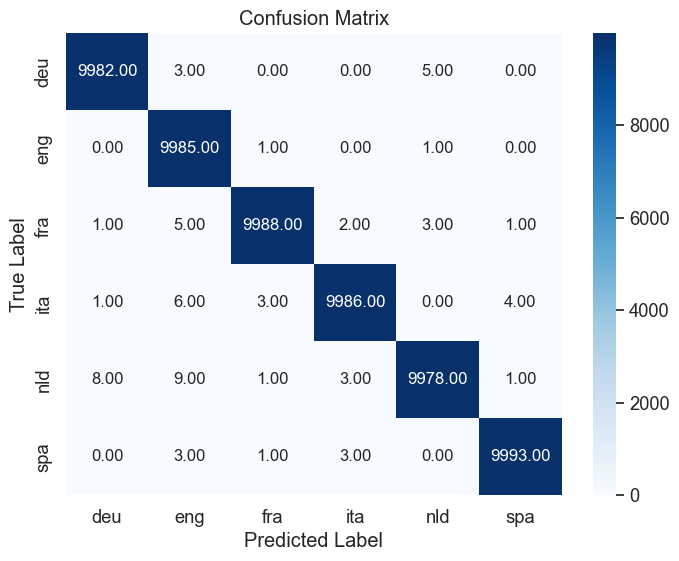

In [38]:
# Predicctions for the test data and calculation of the accuracy and the confusion matrix


accuracy, precision, f1, conf_matrix = evaluate_results(X_test, y_test, trigram_LID, best_lambda, show_missclassified=True)


print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1 score: {f1}')

# Define the class labels
classes = np.unique(y_test)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## EXTRA: MULTINOMIAL NAIVE BAYES MODEL

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [40]:
# Function to load the training data from the files

def load_data_train(filenames):
    texts = []
    labels = []
    for file in filenames:
        with open(file, 'r', encoding='utf-8') as f:
            text = preprocess_text(f.read())
            trigrams = create_trigrams(text)
            texts.append(' '.join(trigrams))
            labels.append(os.path.basename(file).split('_')[0])
    return texts, labels

In [41]:
# Function to load the test data from the files

def load_data_test(filenames):
    texts = []
    labels = []
    for file in filenames:
        label = os.path.basename(file).split('_')[0]  # The tag is the first part of the filename
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                text = preprocess_text(line.strip())  # Preprocess each line
                if text:  # If the line is not empty
                    trigrams = create_trigrams(text)
                    trigram_text = ' '.join(trigrams)  # Convert the trigrams to a single string
                    texts.append(trigram_text)
                    labels.append(label)
    return texts, labels

In [23]:
# Function to filter the infrequent trigrams (appear less than 5 times in a language)

def filter_infrequent_trigrams(texts):
    trigram_counts = Counter(' '.join(texts).split()) 
    frequent_trigrams = {trigram for trigram, count in trigram_counts.items() if count >= 5}
    filtered_texts = [' '.join([trigram for trigram in text.split() if trigram in frequent_trigrams]) for text in texts]
    return filtered_texts

In [42]:
# Load the training and test data

train_files = glob.glob('langId/*_trn.txt')
test_files = glob.glob('langId/*_tst.txt')
X_train, y_train = load_data_train(train_files)
X_test, y_test = load_data_test(test_files)

X_train_filtered = filter_infrequent_trigrams(X_train)

In [43]:
# Vectorize the training and test data

vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train_filtered)
X_test_vect = vectorizer.transform(X_test)

### TRAINING THE MODEL

In [44]:
# Train the Multinomial Naive Bayes model

model = MultinomialNB(alpha=0.5)
model.fit(X_train_vect, y_train)

MultinomialNB(alpha=0.5)

### EVALUATING THE RESULTS

Accuracy: 0.9978158294012704
Precision: [0.99879844 0.99521149 0.99869831 0.99829676 0.9979984  0.99790126]
f1-score: 0.9978160033016766


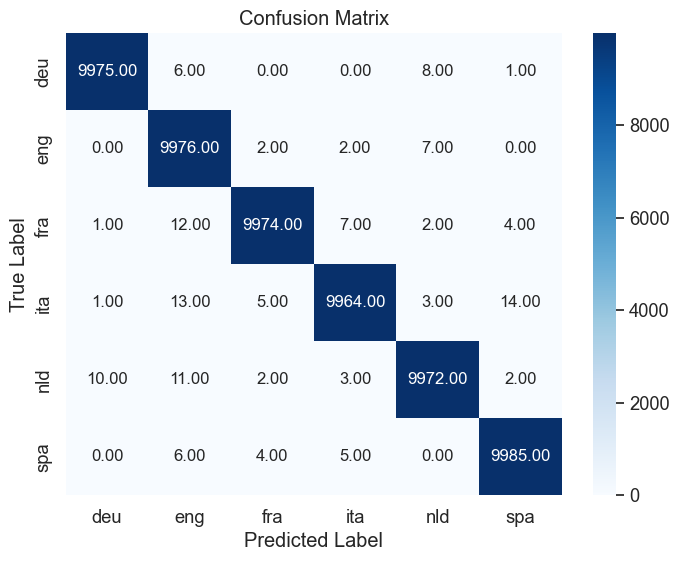

In [46]:
# Evaluate the model

y_pred = model.predict(X_test_vect)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'f1-score: {f1}')

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()